# CESSIPy: an open source Python module for Stochastic System Identification in Civil Engineering

The process of finding a mathematical model of a dynamic system from inputs and/or outputs is called system identification. In a civil engineering context, structures, such as buildings, towers and bridges, are the systems and the identified model is a modal model consisting of eigenfrequencies, damping ratios and modal shapes. 

When the structure is excited by an unmeasurable input force and only output measurements are available, the process is called stochastic system identification.

The CESSIPy (Civil Engineer Stochastic System Identification for Python) estimates the modal parameters from acceleration data. Five system identification methods available:

1. Basic Frequency Domain (BFD) method also called Peak Picking Method (PP) technique.
2. Enhanced Frequency Domain Decomposition (EFDD) method.
3. Covariance-driven Stochastic Subspace Identification (SSI COV) method.
4. Data-driven Stochastic Subspace Identification (SSI DATA) method.
5. Instrumental Variable (IV) method.


In this notebook, the methods are briefly reviewed and the identification is illustrated with an example.

---

## Contents

1. [Example](#1)  


2. [Frequency-Domain Methods](#2)                           
   2.1.  [Spectral densities](#2.1)                                                  
   2.2.  [Basic Frequency Domain (BFD) method](#2.2)                      
   2.3.  [Enhanced Frequency Domain Decomposition (EFDD) method](#2.3)                                       


3. [Time-Domain Methods](#3)                             
   3.1.  [Time data](#3.1)                                       
   3.2.  [Covariance estimates](#3.2)                                           
   3.3.  [Stochastic Subspace Identification (SSI) methods](#3.3)                                                       
   3.3.1.  [Covariance-drive stochastic subspace identification (SSI COV)](#3.3.1)                                     
   3.3.2.  [Data-driven stochastic subspace identification (SSI DATA)](#3.3.2)                                             
   3.3.3.  [Fast multi-order computation of system matrices](#3.3.3)                                                   
   3.4.  [Instrumental Variable (IV) method](#3.4)                                      
 
 
4. [Other functions](#4)                         
   4.1.  [Plotting building's modal parameters](#4.1)                     
   4.2.  [Modal Assurance Criterion (MAC)](#4.2)                                 
   4.3.  [Plotting singular values ](#4.3)                                                                                     
   4.4.  [Reading data from file](#4.4)

In [117]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import CESSIPy           as SSI
from   MRPy import MRPy
%matplotlib inline

## 1. Example <a name="1"></a>

In order to illustrate how to use CESSIPy, an example is introduced. The simulated structure is a three-storey plane frame. The excitation forces are random (zero mean Gaussian white noise generated by `numpy.random.randn` function).  Only three degrees of freedom are considered, corresponding to the floor horizontal displacements at each level. 

Firstly, the vibration experiment is simulated. The eigenfrequencies and the modal shapes are computed from the mass and stiffness matrices. All modal damping ratios are set equal to 1,5%. Random forces are applied, and the structural response is obtained using MRPy class [[11](#ref11)]. 

The building response is then used to illustrate and compare the system identification methods.

<img src="img/1 - Frame.jpg" width="380">

---

The initial parameters are:

In [118]:
m = 0.33   # storey mass [kg]
k = 980    # single column stiffness [N/m]
H = 3      # storey height [m]
ζ = 0.015  # damping ratio [-]

The lumped-mass matrix $\mathbf{M}$ is:

In [119]:
M = np.array(([m, 0, 0],
              [0, m, 0],
              [0, 0, m]))

The stiffness matrix $\mathbf{K}$ is computed by applying unitary displacements at each floor level individually.

<img src="img/2 - Stiffness Matrix.jpg" width="650">

So:

In [120]:
K = np.array(([ 2*k,-2*k,   0],
              [-2*k, 4*k,-2*k],
              [   0,-2*k, 4*k]))

---

In order to calculate the natural frequencies, damping ratios (eigenvalues) and modal shapes (eigenvectors) from a $n$ DOF structure, we start analysing an undamped free vibrations system:

$$ \mathbf{M}\ddot{\vec u} (t) + \mathbf{K} \vec u(t)=0\tag{1}$$

Where $\vec u(t)$ and $\ddot{\vec u}(t)$ are the generalized displacements vector and generalized accelerations vector, respectively.

Using the superposition method, the displacement vector is written as the sum of modal displacements:

$$\vec u (t) = \sum_{i=1}^n u_i(t) \vec \phi_i = \Phi \vec u_m (t) \tag{2}$$

Where $u_i(t)$ is the modal response, $\vec \phi_i$ is the modal shape, $\Phi$ is a matrix containing the modal shapes as columns and $\vec u_m (t)$ is the modal responses vector.

The modal shapes $\vec \phi_i$ and natural frequencies $\omega_i$ are evaluated solving a generalized eigenvalue problem:

$$ \mathbf{K} \vec \phi_i = \omega_i^2 \mathbf{M} \vec \phi_i \tag{3}$$

Which may be rewritten as:

$$ \mathbf{K}^{-1} \mathbf{M} \vec \phi_i = \frac{1}{\omega_i^2} \vec \phi_i \tag{4}$$

In [121]:
Λ, Q = np.linalg.eig(np.linalg.inv(K) @ M) 

The matrix $\mathbf{\Phi}$ is computed by assembling the eigenvectors as columns:

In [122]:
pd.DataFrame(Q,columns=['Mode 1','Mode 2','Mode 3'])

,Mode 1,Mode 2,Mode 3
0,-0.736976,-0.591009,0.327985
1,-0.591009,0.327985,-0.736976
2,-0.327985,0.736976,0.591009


The eigenfrequencies are computed from the eigenvalues ```Λ```:

In [123]:
ωn = (1/Λ)**.5            # circular eigenfrequencies [rad/s]
fn = ωn/(2*np.pi)         # eigenfrequencies [Hz]

for k, j in enumerate(fn):
    print('f{0} = {1:7.4f} Hz'.format(k+1,j))

f1 =  5.4587 Hz
f2 = 15.2950 Hz
f3 = 22.1020 Hz


In many cases, the eigenvectors are mass-normalized:

$$\mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}=\mathbf{I}_n \tag{5}$$

Where $\mathbf{I}_n$ denotes an identity matrix of dimension $n\times n$.

In [124]:
Mk = np.diag(Q.T @ M @ Q)  # modal masses
Q  = Q/Mk**0.5             # mass-normalized eigenvectors

In fact, it can be shown that the modal masses are unitary:

In [125]:
Mk = Q.T @ M @ Q
Mk

array([[ 1.00000000e+00, -2.62148436e-16, -8.53771826e-17],
       [-3.05602135e-16,  1.00000000e+00,  2.04191321e-16],
       [-1.20099306e-16,  1.91557971e-16,  1.00000000e+00]])

Finally, the floor level vector `x` is created and the modal parameters are plotted.

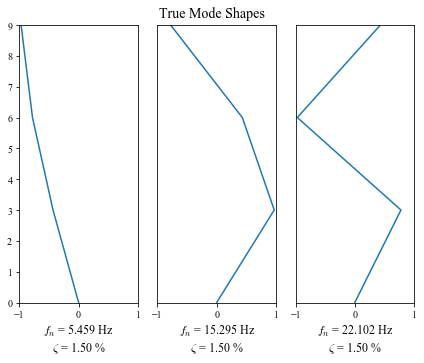

In [126]:
x  = np.linspace(3*H,H,3)
SSI.plot_1dshapes(fn,ζ*np.ones(3),Q,'True',x,fix=[0])

The parameter ```fix=[0]``` adds a zero value to the modal shape on the ground level.

A detailed description of the functions can be easily accessed by writing the function's name followed by `?`.

---
In order to compute the structural response, the number of time samples $N$ and the sampling frequency $f_s$ are defined:

In [127]:
N  = 2**14                              # number of time samples
fs = 64                                 # sampling frequency [Hz]

Random forces with Gaussian distribution are applied at each floor:

In [128]:
F  = MRPy(np.random.randn(3,N),fs=fs)   # forces [N]

The dynamic response of a $n$ DOF system is evaluated solving the dynamic-equilibrium matrix equation:

$$ \mathbf{M}\ddot{\vec u} (t) +\mathbf{C}_f\dot{\vec u} (t)+ \mathbf{K} \vec u(t)=\vec F (t) \tag{6}$$

Where $\mathbf{C}_f$ is the damping matrix, $\dot{\vec u}(t)$ is the velocity vector and $\vec F(t)$ is the load vector.

According to the mode-superposition method, the dynamic-equilibrium matrix equation is transformed into a set of decoupled differential equations, one equation for each mode. Pre-multiplying by $\mathbf{\Phi}^T$ and using the definition $(2)$:

$$ \mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}\ddot{\vec u}_m (t) + \mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi}\dot{\vec u}_m (t)+ \mathbf{\Phi}^T \mathbf{K}\mathbf{\Phi} \vec u_m(t)=\mathbf{\Phi}^T\vec F (t) \tag{7}$$

Where $ \mathbf{\Phi}^T\mathbf{M}\mathbf{\Phi}$ is a diagonal matrix that contains the modal masses $m_i$, $\mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi} $ is the modal damping matrix, $\mathbf{\Phi}^T \mathbf{K}\mathbf{\Phi}$ is a diagonal matrix that contains the modal stiffness $k_i$ and $\mathbf{\Phi}^T\vec F (t) = \vec{F_m}(t)$ is the modal force vector.

The modal forces are:

In [129]:
Fk = MRPy(np.dot(Q.T,F),fs=fs)                     # modal forces

Assuming proportional damping, the eigenvectors diagonalize $\mathbf{C}_f$:

$$\mathbf{\Phi}^T \mathbf{C}_f\mathbf{\Phi} = \mathrm{diag}(c_i) = \mathrm{diag}(2\zeta_i\omega_i m_i) \tag{8}$$

Where $c_i$ is the modal damping and $\zeta_i$ is the damping ratio.

Therefore, the matrix equation $(6)$ is rewritten as decoupled differential equations, one for each mode:

$$m_i \ddot u_i (t)+ c_i \dot u_i (t) + k_i u_i (t) = F_i (t) \tag{9}$$

Which can be solved individually in the frequency domain.

In [130]:
Xk = MRPy.sdof_Fourier(Fk,fn,ζ)                     # modal responses

From equation $(2)$, the displacements are obtained and also the accelerations.

In [131]:
X  = MRPy(np.dot(Q,Xk),fs=fs)                      # displacements
A  = MRPy.differentiate(MRPy.differentiate(X))     # accelerations

The acceleration time series are the only data that the identification methods require.
They can be easily plotted.

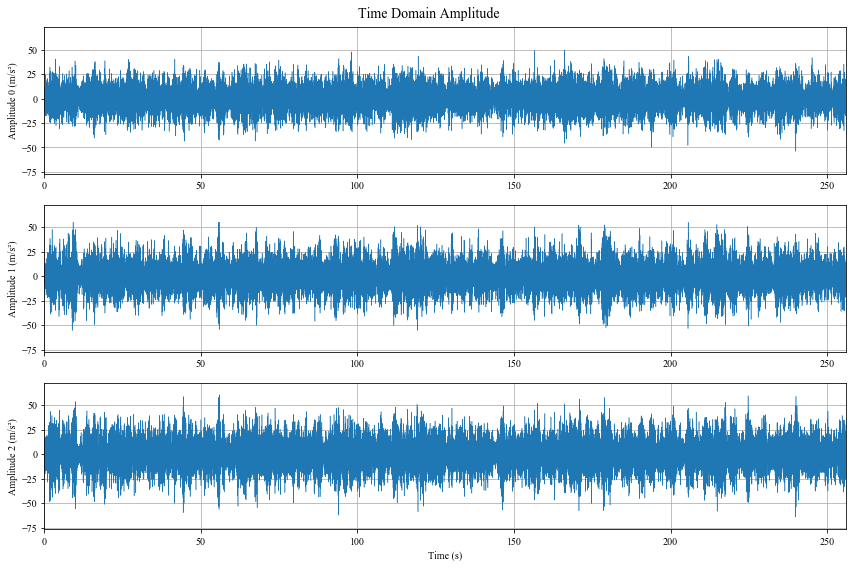

In [132]:
h1 = A.plot_time(unit=' (m/s²)')

---
## 2. Frequency Domain Methods <a name="2"></a>

The system identification methods can be divided according to the type of data that they require: raw time data, covariances or spectra [[10](#ref10)]. We start with frequency domain methods to correspond the historical application of stochastic system identification methods.

### 2.1. Spectral densities <a name="2.1"></a>

The BFD and EFDD methods assume that the inputs are random (white noise). The first step is to estimate the response spectral density matrix  $\mathbf{G}(f)$:

$$ \mathbf{G}(f) = E\left[\mathbf{Y}(f)\mathbf{Y}^{H}(f)\right] \tag{10}$$

Where $\mathbf{Y}$ is the frequency domain structure response. The superindex $(\cdot)^H$ denotes complex conjugate transpose and $E[\cdot]$ expected value.

The spectral matrix can be estimated and plotted using `SDM` function, which uses `scipy.signal.csd` function. The signals are split into segments with `nperseg` values to reduce the variance of the estimate. By default, a Hanning window is used.

A visualization of the spectral matrix is shown below.

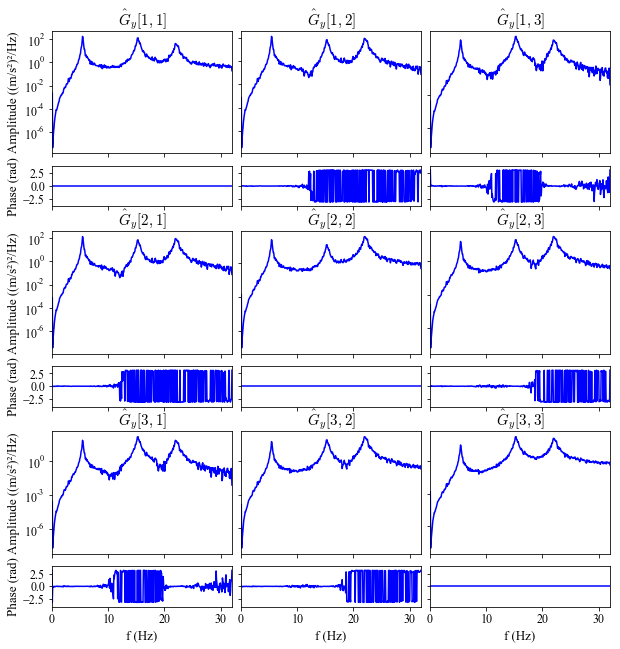

In [133]:
nps = A.N//16
PSD = SSI.SDM(A, nperseg=nps, plot=True) 

The spectral matrix is a three-dimensional array `PSD`. The first and second array indexes correspond to the signals and the third corresponds to the frequency. For example, the spectral density functions at the frequency $f=0$ are:

In [134]:
PSD[:,:,0]

auxclass([[ 0.00448644+0.j,  0.00147154+0.j, -0.00054949+0.j],
          [ 0.00147154+0.j,  0.00296129+0.j,  0.0002643 +0.j],
          [-0.00054949+0.j,  0.0002643 +0.j,  0.00315223+0.j]])

Note that `PSD` is an object. It contains frequencies as attribute `PSD.f` and the segment length `PSD.nperseg`.

### 2.2. Basic Frequency Domain (BFD) method <a name="2.2"></a>

The simplest approach to estimate modal parameters is the Peak-Picking method, also called Basic Frequency Domain (BFD) method. As its name suggests, the eigenfrequencies are identified as the peaks of spectral density functions. For lightly damped structures with well separated modes, both autospectral density and cross-spectral density functions reach local maxima at the resonant frequency $f_r$. In this frequency, the spectral matrix can be approximated as:

$$ \mathbf{G}(f_r) \approx \alpha_r\vec\phi_r\vec\phi^H_r \tag{11}$$

Where $\alpha_r$ is a factor determined by the natural frequency, damping ratio and modal shape and $\vec\phi_r$ is an estimate of the modal shape.

The Averaged Normalized Power Spectral Density (ANPSD), proposed by Felber [[7](#ref7)], assembles all autospectral data in one graph. The procedure starts selecting the peaks of the ANPSD.

The functions created are named `ANPSD_from_SDM` and `BFD` and they have two modes: `'interactive'` and `'batch'`. First, the default `'interactive'` mode is described.

After calling `ANPSD_from_SDM`, a window is shown and the user should select the peaks with the left mouse button. The black crosshair displays the frequency which will be picked (please ignore the red cross at the location of each click). Once all peaks are marked, the middle mouse button should be pressed. Use right button to undo last click. An example is displayed below.

<img src="img/3 - ANPSD en.jpg" width="800">

Click on the field below, press Enter and use the mouse to select the graph's peaks.

In [135]:
input ('Press Enter to continue')

%matplotlib qt
PSD = SSI.ANPSD_from_SDM(PSD)

Press Enter to continue


The object `PSD` receives the attributes `PSD.ANPSD` and `PSD.pki` that contains the ANPSD values and the peak indexes, respectively.

The natural frequencies estimated by the BFD method are:

In [136]:
for k, j in enumerate(PSD.pki):
    print('fn{0} = {1:7.4f} Hz'.format(k+1,PSD.f[j]))

fn1 =  5.4375 Hz
fn2 = 15.3125 Hz
fn3 = 21.9375 Hz


As described, the default `ANPSD_from_SDM` mode is `'interactive'`and the peaks are selected with the mouse.
The natural frequencies can be changed by modifying the attribute `PSD.pki`.

Another mode is called `'batch'` and it allows automated code execution, without user interaction. The attribute `PSD.pki` must be specified.

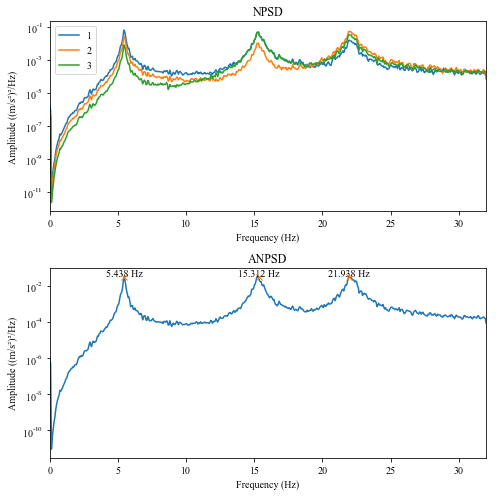

In [137]:
%matplotlib inline
PSD = SSI.ANPSD_from_SDM(PSD,mode='batch',plot=True)

The modal shapes and damping ratios are estimated by the `BFD` function. 

Two methods are implemented: the half-power method and spectral curve fitting method.

The half-power bandwidth method estimates the damping from the peak frequency $f_r$ and the two half-power frequencies $f_a$ and $f_b$ [[6](#ref6)]:

$$\zeta_i = \frac{f_b^2-f_a^2}{4f_r^2} \tag{12}$$

On the curve fitting method, the values near the peak are selected and fitted to the theoretical acceleration response power spectral density function of a single DOF system excited by an input with a constant spectral value:

$$G_y(f) = C_1 \left| \frac{f^2}{1-\left(f / f_n\right)^2+j2\zeta\left(f / f_n\right)}\right|^2 + C_2 \tag {13}$$

Where $C_1$ is a factor determined by the system stiffness and the input spectrum, $f_n$ is the undamped natural frequency, $\zeta$ is the damping ratio, $j$ is the imaginary unit and $C_2$ is a factor that takes into account the influence of others modes.

Once the function is called, it runs on the default `'interactive'` mode. The user should select the autospectral density used in the curve fit procedure (usually the one with highest peak value), as displayed in the figure below.

<img src="img/4 - Autospectral.jpg" width="700">

Then, the user should inform the lower and upper limits of the function, for example:

<img src="img/5 - Autospectral.jpg" width="600">

The code below shows the function call. Press Enter to make the graphical selection.

In [138]:
input('Press Enter to continue')

%matplotlib qt
FBFD, ZBFD, VBFD, PSD = SSI.BFD(A, PSD, plot=False)

Press Enter to continue
Select the reference autospectral density


`ZBFD[0]` and `ZBFD[1]` are the damping ratios estimated by the half-power method and by the curve fitting method, respectively.

In [139]:
print('Half-Power  Curve Fitting')
for j, (k,l) in enumerate(zip(ZBFD[0],ZBFD[1])):
    print('ζ{0} = {1:4.2f}%     ζ{0} = {2:4.2f}%'.format(j+1,k*100,l*100))

Half-Power  Curve Fitting
ζ1 = 1.52%     ζ1 = 1.36%
ζ2 = 1.33%     ζ2 = 1.36%
ζ3 = 1.60%     ζ3 = 1.44%


The identified modal parameters are:

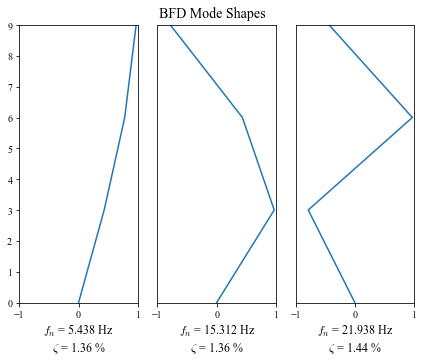

In [140]:
%matplotlib inline
SSI.plot_1dshapes(FBFD,ZBFD[1],VBFD,'BFD',x,fix=[0])

After calling the `BFD` function, the `PSD` object receives some attributes:

In [141]:
PSD.pki # peak indexes

array([ 87, 245, 351], dtype=int64)

In [142]:
PSD.MGi # signal index used to damping estimation

array([0, 2, 1])

In [143]:
PSD.fint # lower and upper limits used by the curve fitting

array([ 3.75  ,  7.9375, 13.0625, 18.    , 20.125 , 24.5625])

These attributes can be modified for fine-tuning. It is also possible to create them before calling the function, what allows the use of the `'batch'` mode.

The argument `plot=True` displays the graphs of autospectral density and damping estimations.

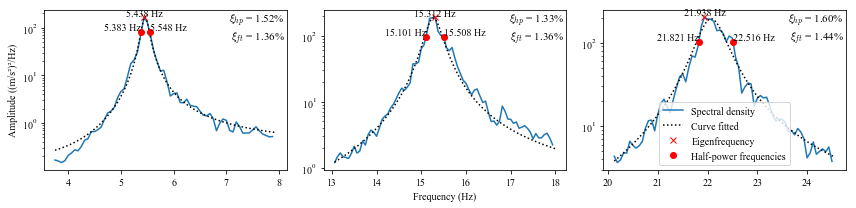

In [144]:
FBFD, ZBFD, VBFD, PSD = SSI.BFD(A, PSD, plot=True, mode='batch')

The coherence function between two channels tends to go to one at the resonant frequencies. Consequently, inspecting the coherence function can assist in selecting the eigenfrequencies [[10](#ref10)].

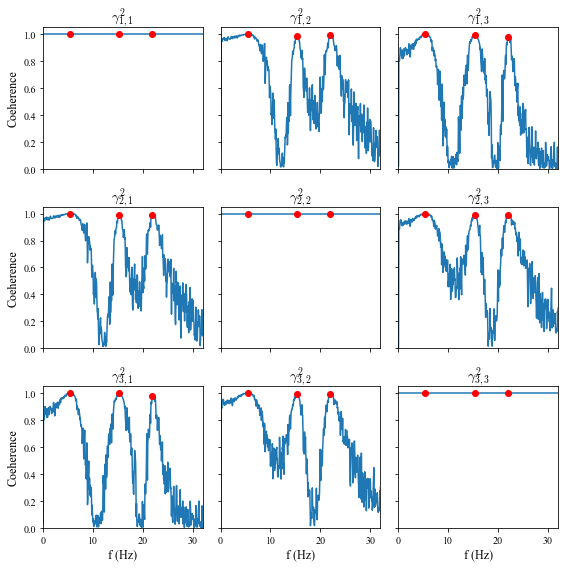

In [145]:
γ   = SSI.coherence(A, PSD, nps, plot=True)

### 2.3. Enhanced Frequency Domain Decomposition (EFDD) method <a name="2.3"></a>

The EFDD method [[3](#ref3),[4](#ref4)] computes the Singular Value Decomposition (SVD) of the spectrum matrix for each frequency, decoupling the structural system into a series of single DOF systems. The spectral matrix SVD is:

$$\mathbf{G}(f)=\mathbf{U}(f)\mathbf{\Sigma}(f)\mathbf{U}^{H}(f) \tag{14}$$

Where $\mathbf{\Sigma}$ is a diagonal matrix that contains the singular values in descending order and $\mathbf{U}$ is a complex unitary matrix containing the singular vectors. If only one mode is relevant at the resonant frequency $f_r$, the spectral matrix can be approximated as a rank-one matrix only considering the maximum singular value:

$$\mathbf{G}(f)\cong \sigma_1(f_r)\vec u_1(f_r)\vec u_1^H(f_r) \tag{15}$$

The first singular vector $\vec u_1(f_r)$ is an estimation of the modal shape $\vec\phi_r$. In the case of closely spaced modes, more than one singular value will reach a maximum around a given frequency, and all singular vectors corresponding to non-zero singular values are modal shape estimates [[8](#ref8)].

In assessing the spectral density functions, Bendat and Piersol [[2](#ref2)] do not recommend using any window, what can be done by specifying `window='boxcar'`. The authors also recommend to augment each block of `nps` data values with `nps` zeros, what can be done specifying `nfft=2*nps`.

In [146]:
P2SD = SSI.SDM(A, nperseg=nps, plot=False,window='boxcar',nfft=2*nps) 

The function created is named `EFDD` and it runs on the `'interactive'` mode by default.

After calling the function, the user should click on the peaks of the singular values:
<img src="img/6 - Singular Values.jpg" width="600">

Next, the lower and upper limits around the peak are selected. Outside these limits, the spectral density is set to zero. 

In order to help the limits' choice, the Modal Assurance Criterion (MAC) between the peak's singular vector and the others is calculated. MAC is a measure of correlation between two modal shapes. The MAC varies between 0 and 1, being equal to zero for non-correlated modes and one for perfectly correlated modes (for more details, see [4.2](#4.2)). The frequencies where MAC > 0.8 are shown in orange.

<img src="img/7 - Frequencies.jpg" width="600">

The autocorrelation function is obtained after computing the inverse Fast Fourier Transform (FFT) of the autospectral density. From the autocorrelation function, the natural frequency and the damping ratio are estimated by curve fitting the free decay function: 

$$y(t) = y_p \exp^{-\eta t}\cos \left ( \omega_d t \right) \tag{16}$$

Where $y_p$ is the amplitude, $\eta = \omega_n \zeta$ and $\omega_d$ the damped natural frequency $\omega_d = \omega_n \sqrt{1-\zeta^2}$.

The limits of the autocorrelation are specified by the user. The absolute values are plotted to facilitate the definition of the limits.

<img src="img/8 - Autocorrelation.jpg" width="400">

There are two steps in the curve fitting procedure. First, an exponential curve $y(t) = y_p \exp^{-\eta t}$ is fitted, computing $\eta$ and $y_p$. Then, the free decay function is fitted calculating $f_n$ and $\zeta$.

In [147]:
input('Press Enter to continue')

%matplotlib qt
FFDD, ZTFDD, VFDD, P2SD = SSI.EFDD(A,P2SD,plot=False)

Press Enter to continue
Peak selection


The estimated modal parameters are shown below.

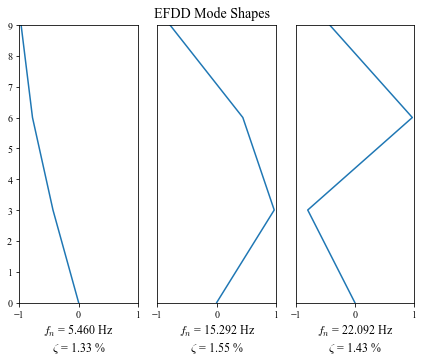

In [148]:
%matplotlib inline
SSI.plot_1dshapes(FFDD,ZTFDD,VFDD,'EFDD',x,fix=[0])

After calling the `EFDD` function, the `P2SD` object receives some attributes:

In [149]:
P2SD.pki  # peak indexes of the spectral density

array([175, 490, 703], dtype=int64)

In [150]:
P2SD.svi  # singular value peak indexes

array([0, 0, 0], dtype=int64)

In [151]:
P2SD.fint # lower and upper frequencies limits

array([ 3.625  ,  9.15625, 13.125  , 17.6875 , 20.3125 , 24.65625])

In [152]:
P2SD.tint # lower and upper time limits

array([0.0625 , 2.9375 , 0.03125, 1.375  , 0.0625 , 1.09375])

These attributes can be modified. It is also possible to create them before the function call, and then using the `'batch'` mode to avoid mouse input.

The figure below displays the autocorrelation discrete values and the curve fitted.

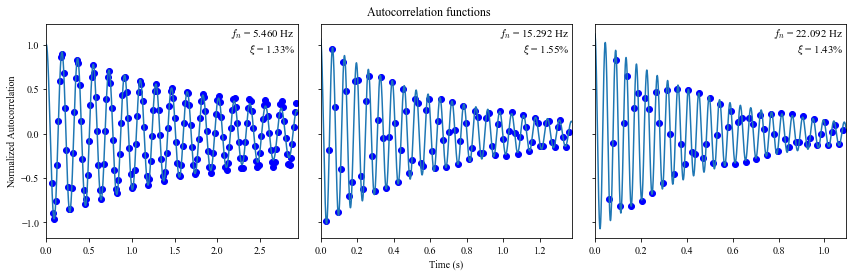

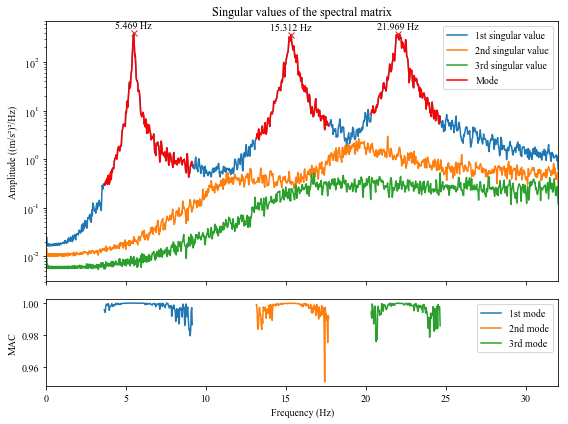

In [153]:
%matplotlib inline
FFDD, ZTFDD, VFDD, P2SD = SSI.EFDD(A,P2SD,plot=True, mode='batch')

## 3. Time-Domain methods <a name="3"></a>

In this section, the Instrumental Variable (IV) method, the Covariance-Driven Stochastic Subspace Identification (SSI COV) method and the Data-Driven Stochastic Subspace Identification (SSI DATA) are reviewed. A unified approach is adopted, very similar to that presented by Peeters [[10](#ref10)] and Rodrigues [[12](#ref12)].

### 3.1. Time data <a name="3.1"></a>

The $l$ outputs are split in a subset of $r$ signals or well-chosen reference sensors and a subset of $(l-r)$ other sensors. 

$$ \vec y_{k} = \begin{bmatrix} \vec y_{k}^{ref} \\ \vec y_{k}^{\backsim} \end{bmatrix} \tag{17}$$

Where $\vec y_{k}^{ref}$ are the reference outputs and $\vec y_{k}^{\backsim}$ are the others.

The `rearrange_data` function receives the time data and the reference sensors as arguments and computes $ \vec y_{k}$:

In [154]:
ref = (0,1,2)   # all three sensors are reference sensors                

yk = SSI.rearrange_data(A,ref)

If, for example, only the first sensor is a reference sensor, the argument is `ref=(0)`.

The outputs are gathered in a block Hankel matrix $\mathbf{H}^{ref} \in \mathrm{\mathbb{R}}^{(r+l)i\times N}$ (a matrix that its anti-diagonal is constant) with $2i$ block rows and $N$ columns. The first $i$ blocks have $r$ rows each and the last $i$ have $l$ rows. This matrix can be divided into a past reference part (subscript p) and a future part (subscript f), according to equation $(18)$:

$$\mathbf{H}^{ref} = \frac{1}{\sqrt{N}} \begin{bmatrix} 
                     \vec y_{0}^{ref}   & \vec y_{1}^{ref} & \cdots & \vec y_{N-1}^{ref}   \\ 
                     \vec y_{1}^{ref}   & \vec y_{2}^{ref} & \cdots & \vec y_{N}^{ref}     \\
                     \vdots             & \vdots           & \ddots & \vdots               \\ 
                     \vec y_{i-1}^{ref} & \vec y_{i}^{ref} & \cdots & \vec y_{i+N-2}^{ref} \\ \hline
                     \vec y_{i}         & \vec y_{i+1}     & \cdots & \vec y_{i+N-1}       \\
                     \vec y_{i+1}       & \vec y_{i+2}     & \cdots & \vec y_{i+N}         \\
                     \vdots             & \vdots           & \ddots & \vdots               \\
                     \vec y_{2i-1}      & \vec y_{2i}      & \cdots & \vec y_{2i+N-1}  \end{bmatrix} 
                     = 
                     \begin{bmatrix} \mathbf{Y}_{p}^{ref} \\ \hline \mathbf{Y}_{f}\end{bmatrix}
                     \begin{matrix} \updownarrow ri \\ \updownarrow li\end{matrix}
                     \frac{\mathrm{"past"}}{\mathrm{"future"}} \tag{18}$$
                 

### 3.2. Covariance estimates <a name="3.2"></a>
 
The output covariances are gathered in a block Toeplitz matrix $\mathbf{T}_{1|i}^{ref} \in \mathrm{\mathbb{R}}^{li\times ri}$ computed from the data block Hankel matrix:

$$\mathbf{T}_{1|i}^{ref} = \mathbf{Y}_{f} (\mathbf{Y}_{p}^{ref})^{T} = \begin{bmatrix} 
  \mathbf{R}_{i}^{ref}    & \mathbf{R}_{i-1}^{ref}  & \cdots & \mathbf{R}_{2}^{ref}   & \mathbf{R}_{1}^{ref} \\ 
  \mathbf{R}_{i+1}^{ref}  & \mathbf{R}_{i}^{ref}    & \cdots & \mathbf{R}_{3}^{ref}   & \mathbf{R}_{2}^{ref} \\
  \vdots                  & \vdots                  & \ddots & \vdots                 & \vdots               \\ 
  \mathbf{R}_{2i-1}^{ref} & \mathbf{R}_{2i-2}^{ref} & \cdots & \mathbf{R}_{i+1}^{ref} & \mathbf{R}_{i}^{ref} \end{bmatrix} \tag{19}$$

The parameter $i$ is a user's choice. Note that the covariance functions are evaluated up to $2i-1$ time lags. A usual choice is $ i=40 $:

In [155]:
i = 40

### 3.3. Stochastic Subspace Identification (SSI) methods <a name="3.3"></a>

The SSI methods identify a discrete-time stochastic state-space model and the system's matrices are computed from output data:

$$ \vec x_{k+1} = \mathbf{A} \vec x_{k} + \vec w_{k} \tag{20}$$

$$ \vec y_{k}   = \mathbf{C} \vec x_{k} + \vec z_{k} \tag{21}$$

Where $\vec x_{k}= [\vec u_k \ddot{\vec u_k} ]^T$ is the state vector at time $k$ ($k=0,1,...,N-1$ with $N$ the number of time samples), $\vec w_{k}$ is the process noise due to disturbances and modelling inaccuracies, $\vec y_{k}$ is the output vector, $ \vec z_{k}$ is the measurement noise due to sensor inaccuracy, $\mathbf{A}$ is the state matrix and $\mathbf{C}$ is the observation matrix.

Estimating the model matrices $\mathbf{A}$ and $\mathbf{C}$ with covariance (SSI COV) or time data (SSI DATA), the modal parameters are identified [[8](#ref8),[9](#ref9)]. The eigenfrequencies $f_{i}$, damping ratios $\zeta_{i}$ and modal shapes $\vec\phi_{i}$ are calculated:

$$\mathbf{A} = \mathbf{\Psi\Lambda}_{d}\mathbf{\Psi}^{-1}, 
\mathbf{\Lambda}_{d}=\mathrm{diag}(\mu_i)\in\mathrm{\mathbb{C}}^{n_2×n_2} \tag{22a}$$

$$ \lambda_i=\frac{\ln\mu_i}{\Delta t} \tag{22b}$$

$$ f_i = \frac{|\lambda_i|}{2\pi} \tag{22c}$$

$$ \zeta_i = \frac{\mathrm{real}(\lambda_i)}{|\lambda_i|} \tag{22d}$$

$$ \mathbf{V} = \mathbf{C} \mathbf{\Psi}, \mathbf{V}= [\vec\phi_{1}...\vec\phi_{n}] \tag{22e}$$

Where $ \mathbf{\Psi}$ and $\mathbf{\Lambda}_{d}$ are the eigenvector and eigenvalue matrices of $\mathbf{A}$, $\mu_i$ and $\lambda_i$ are the discrete and continuous eigenvalues, respectively. $\Delta t$ is the sampling time and $|\cdot|$ denotes the complex modulus.

The number of lines of the state vector $n_2$ is called model order or number of states. The identification process is performed for models with increasing orders and the identification of the true vibration modes is done inspecting the stabilization diagram. It is not possible to predict the order that best fits the experimental data and that provides more realistic dynamic properties. So, the most appropriate way is to overestimate it. High-order models leads to the introduction of numerical modes, which have no physical importance. A common practice for separating physical from spurious modes is the creation of stabilization diagrams. The modal parameters estimated for all models are represented together, allowing the identification of stable modes for models of different orders. Modes that appear with similar eigenfrequencies, damping ratios and modal shapes are classified as stable and are probably physical modes.

In order to distinguish between true and spurious modes, it is necessary to define limits. These tolerances are specified in a two-dimensional `tol` array. The first row is dedicated to the frequencies, the second to the damping ratios and the third to the MAC computed between modal shapes. In the first column are the relative variations for a mode to be classified as stable, in the second column the lower (absolute) limit and in the third the upper limit. For example, the first row `[0.01, 0, 30]` means that frequency's tolerance is 1%, the lower limit for natural frequency is 0 Hz and the upper limit is 30 Hz. Poles outside this range are taken as spurious.

In [156]:
# tolerances: relative variation, lower limit and upper limit
tol = np.array(([0.01,0, 30],       # frequency
                [0.05,0,.03],       # damping
                [0.10,0,1  ]))      # MAC

### 3.3.1. Covariance-Driven Stochastic Subspace Identification (SSI COV) <a name="3.3.1"></a>

The SSI COV addresses the problem of stochastic realization, i.e., the problem of identifying a stochastic state space model from output-only measurements. This method is based on the SVD of the covariance matrix  of the outputs $(19)$. A detailed description is presented by Peeters [[10](#ref10)].

The `SSI_COV` function identifies the system of a given state order and the` SSI_COV_iterator` function iterates the `SSI_COV` function for ascending order models. The Toeplitz matrix and its SVD decomposition are calculated only once. The inequality $ ri≥n_ {2, max} $ must be satisfied where $ n_ {2, max} $ is the maximum state space order. Lower-order models $ n_2 <n_ {2, max} $ are easily computed by selecting fewer singular values.

Given a model of minimum order equals to 2, maximum order equals to 20 and a (default) step equals to 2:

In [157]:
FNC, ZTC, VVC = SSI.SSI_COV_iterator(yk,i,2,20)

`FNC` and `ZTC` are two-dimensional arrays that contain the natural frequency and damping ratio estimates. Each row belongs to a certain model order. The first row contains the identified modal model of order $ n_2 = 2 $ and the last row contains the modal model of order $n_2 = 20$. For example, the frequencies and damping ratios estimated for the $ n_2 = 16 $ order model are:

In [158]:
df = pd.DataFrame(np.array((FNC[7,:],ZTC[7,:])))
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5.454,5.454,24.919,24.919,23.511,23.511,22.096,22.096,21.687,21.687,15.297,15.297,15.332,15.332,18.518,18.518,0.000,0.000,0.000,0.000
1,0.014,0.014,-0.003,-0.003,0.009,0.009,0.014,0.014,-0.022,-0.022,0.015,0.015,-0.018,-0.018,0.009,0.009,0.000,0.000,0.000,0.000


And the respective modal shapes:

In [159]:
df = pd.DataFrame(VVC[7,:,:])
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.458-1.259j,-4.458+1.259j,0.118-0.102j,0.118+0.102j,0.368+0.382j,0.368-0.382j,-1.966-3.681j,-1.966+3.681j,-0.103-0.052j,-0.103+0.052j,4.566+4.266j,4.566-4.266j,0.320+0.098j,0.320-0.098j,-0.067+0.438j,-0.067-0.438j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
1,-3.574-1.012j,-3.574+1.012j,-0.245+0.200j,-0.245-0.200j,-0.414-0.662j,-0.414+0.662j,4.469+8.333j,4.469-8.333j,0.289-0.085j,0.289+0.085j,-2.542-2.333j,-2.542+2.333j,-0.281-0.226j,-0.281+0.226j,0.026-0.442j,0.026+0.442j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j
2,-1.985-0.556j,-1.985+0.556j,0.119-0.273j,0.119+0.273j,0.374+0.477j,0.374-0.477j,-3.610-6.812j,-3.610+6.812j,-0.319+0.073j,-0.319-0.073j,-5.704-5.272j,-5.704+5.272j,-0.617-0.119j,-0.617+0.119j,0.012-0.124j,0.012+0.124j,0.000+0.000j,0.000+0.000j,0.000+0.000j,0.000+0.000j


Note that the modal shapes are complex conjugate pairs because the state vector's definition. Consequently, the same mode is represented by two states.

A stabilization diagram is drawn and the true modes are identified from the stable poles. When a new mode is detected, it is represented by a black dot. If only its frequency stabilizes (respecting the limits of `tol [0]`), the dot is green. If in addition to the frequency, the damping ratio respects `tol [1]`, the dot is blue. Finally, if the frequency, damping ratio and modal shape are stable, that is, if the entire `tol` array is respected, the dot is red.

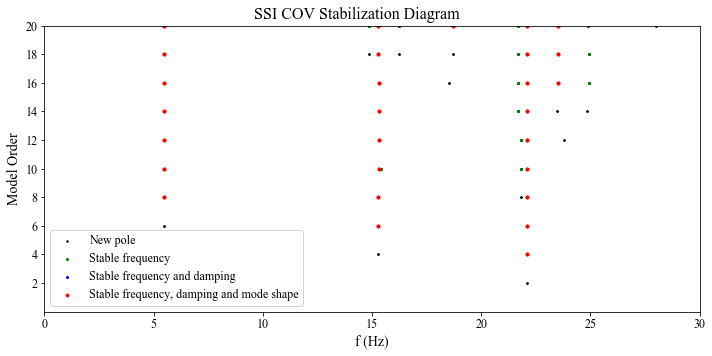

In [160]:
stbC = SSI.stabilization_diagram(FNC,ZTC,VVC,'SSI COV', tol=tol)

If the mode is physical, its modal parameters stabilize for different model orders. The vertical red dot lines are probably physical modes.

`stbC` is a boolean array returned by the `stabilization_diagram` that indicates the stable modes. It is possible to select the natural frequencies and the damping ratios of these stable modes:

In [161]:
df = pd.DataFrame(np.array((FNC[stbC],ZTC[stbC])))
df.style.format('{:.4f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,22.0851,22.0851,22.0851,22.0851,15.2864,15.2864,22.0928,22.0928,15.2864,15.2864,5.4543,5.4543,22.0928,22.0928,5.4543,5.4543,15.3005,15.3005,22.0921,22.0921,5.4543,5.4543,15.2969,15.2969,5.4543,5.4543,22.0966,22.0966,15.2969,15.2969,5.4543,5.4543,23.5111,23.5111,22.0959,22.0959,15.2966,15.2966,5.4543,5.4543,23.5026,23.5026,22.0960,22.0960,15.2890,15.2890,5.4543,5.4543,23.5025,23.5025,22.0961,22.0961,15.2890,15.2890,18.7007,18.7007
1,0.0137,0.0137,0.0137,0.0137,0.0147,0.0147,0.0137,0.0137,0.0147,0.0147,0.0141,0.0141,0.0137,0.0137,0.0141,0.0141,0.0151,0.0151,0.0136,0.0136,0.0141,0.0141,0.0152,0.0152,0.0141,0.0141,0.0137,0.0137,0.0152,0.0152,0.0141,0.0141,0.0091,0.0091,0.0137,0.0137,0.0152,0.0152,0.0141,0.0141,0.0090,0.0090,0.0137,0.0137,0.0152,0.0152,0.0141,0.0141,0.0088,0.0088,0.0137,0.0137,0.0152,0.0152,0.0034,0.0034


And the respective modal shapes:

In [175]:
VE = [[],[],[]]
for j in range(stbC.shape[0]):
    VE = np.hstack((VE,VVC[j,:,stbC[j]].T))
df = pd.DataFrame(VE)
df.style.format('{:.3f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,-3.812+1.774j,-3.812-1.774j,-3.812+1.774j,-3.812-1.774j,-4.526-4.346j,-4.526+4.346j,3.793-1.799j,3.793+1.799j,-4.526-4.346j,-4.526+4.346j,-4.458-1.259j,-4.458+1.259j,3.794-1.800j,3.794+1.800j,-4.458-1.259j,-4.458+1.259j,-4.559-4.204j,-4.559+4.204j,-3.767+1.784j,-3.767-1.784j,-4.458-1.259j,-4.458+1.259j,4.573+4.268j,4.573-4.268j,-4.458-1.259j,-4.458+1.259j,1.972+3.675j,1.972-3.675j,-4.572-4.267j,-4.572+4.267j,-4.458-1.259j,-4.458+1.259j,0.368+0.382j,0.368-0.382j,-1.966-3.681j,-1.966+3.681j,4.566+4.266j,4.566-4.266j,-4.458-1.259j,-4.458+1.259j,-0.364-0.386j,-0.364+0.386j,1.966+3.681j,1.966-3.681j,-4.538-4.336j,-4.538+4.336j,-4.458-1.259j,-4.458+1.259j,-0.360-0.386j,-0.360+0.386j,-1.966-3.681j,-1.966+3.681j,4.538+4.335j,4.538-4.335j,0.403+0.036j,0.403-0.036j
1,8.614-4.056j,8.614+4.056j,8.613-4.057j,8.613+4.057j,2.552+2.390j,2.552-2.390j,-8.569+4.102j,-8.569-4.102j,2.552+2.389j,2.552-2.389j,-3.575-1.013j,-3.575+1.013j,-8.570+4.102j,-8.570-4.102j,-3.575-1.013j,-3.575+1.013j,2.529+2.292j,2.529-2.292j,8.527-4.077j,8.527+4.077j,-3.574-1.013j,-3.574+1.013j,-2.547-2.333j,-2.547+2.333j,-3.574-1.012j,-3.574+1.012j,-4.475-8.324j,-4.475+8.324j,2.545+2.333j,2.545-2.333j,-3.574-1.012j,-3.574+1.012j,-0.414-0.662j,-0.414+0.662j,4.469+8.333j,4.469-8.333j,-2.542-2.333j,-2.542+2.333j,-3.574-1.013j,-3.574+1.013j,0.408+0.663j,0.408-0.663j,-4.470-8.332j,-4.470+8.332j,2.537+2.374j,2.537-2.374j,-3.574-1.012j,-3.574+1.012j,0.405+0.659j,0.405-0.659j,4.470+8.330j,4.470-8.330j,-2.537-2.374j,-2.537+2.374j,-0.408-0.063j,-0.408+0.063j
2,-7.045+3.278j,-7.045-3.278j,-7.045+3.278j,-7.045-3.278j,5.676+5.347j,5.676-5.347j,7.007-3.311j,7.007+3.311j,5.676+5.348j,5.676-5.348j,-1.984-0.556j,-1.984+0.556j,7.006-3.310j,7.006+3.310j,-1.984-0.556j,-1.984+0.556j,5.694+5.230j,5.694-5.230j,-6.976+3.286j,-6.976-3.286j,-1.984-0.556j,-1.984+0.556j,-5.706-5.270j,-5.706+5.270j,-1.984-0.556j,-1.984+0.556j,3.610+6.806j,3.610-6.806j,5.707+5.270j,5.707-5.270j,-1.985-0.556j,-1.985+0.556j,0.374+0.477j,0.374-0.477j,-3.610-6.812j,-3.610+6.812j,-5.704-5.272j,-5.704+5.272j,-1.985-0.556j,-1.985+0.556j,-0.368-0.485j,-0.368+0.485j,3.611+6.812j,3.611-6.812j,5.687+5.352j,5.687-5.352j,-1.985-0.556j,-1.985+0.556j,-0.363-0.481j,-0.363+0.481j,-3.611-6.810j,-3.611+6.810j,-5.685-5.353j,-5.685+5.353j,-0.110-0.029j,-0.110+0.029j


The `stable_modes` function gathers the stable poles. The relative frequency tolerance `tol=0.01` must be specified (it is 1% for current example). Close poles are assembled into a single mode. The minimum number of poles for a mode to be classified as stable must be specified. For example, `spo = 8` indicates that there must be at least six close stable poles to get a stable mode.

In [176]:
FNCR, ZTCR,VVCR = SSI.stable_modes(FNC, ZTC, VVC, stbC, tol=0.01, spo=8)

The modal parameters identified are:

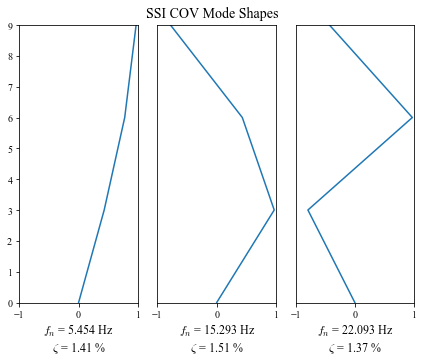

In [177]:
SSI.plot_1dshapes(FNCR,ZTCR,VVCR,'SSI COV',x,ref,fix=[0])

### 3.3.2. Data-driven stochastic subspace identification (SSI DATA) <a name="3.3.2"></a>

The SSI DATA method avoids calculating the output covariance functions. It is replaced by the projection of the lines of the future outputs in the lines of the past outputs, which is calculated from the QR factorization of the block Hankel matrix $(18)$. In fact, the concept of covariance and projections are closely linked. Both aim to cancel the noise. The idea of the projection is to retain all past information useful to predict the future. The method employs the SVD of the projection matrix to compute the observability matrix and the Kalman filter state sequence. The system matrices are computed from the Kalman filter state sequence [[9](#ref9)].


The same remarks as in the SSI COV method concerning the determination of the model order applies here [[10](#ref10)]. The `SSI_DATA_iterator` function iterates the `SSI_DATA` function for ascending model orders. A stabilization diagram is drawn and the physical modes are identified from the stable poles. The QR decomposition, the projections and their SVD are calculated only once, respecting the inequality $ri≥n_{2,max}$, where $n_{2,max}$ is the maximun state space order. Lower order models $n_2<n_{2,max}$ are easily evaluated by selecting fewer singular values.

Given a model of minimum order equals to 2, maximum equals to 20 and a (default) step equals to 2:

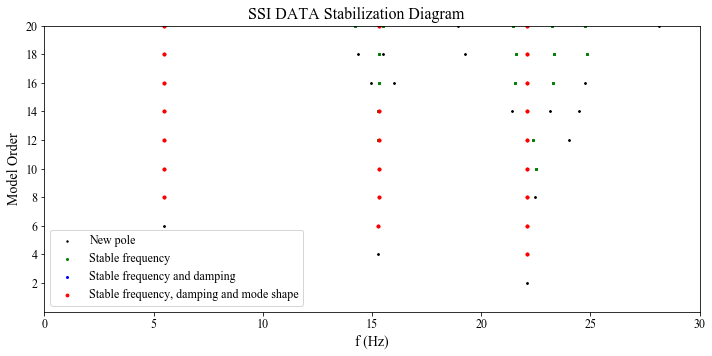

In [178]:
FND, ZTD, VVD = SSI.SSI_DATA_iterator(yk,i,2,20,2)
stbD = SSI.stabilization_diagram(FND,ZTD,VVD,'SSI DATA', tol=tol)

The stable poles are assembled and the identified modal parameters are plotted.

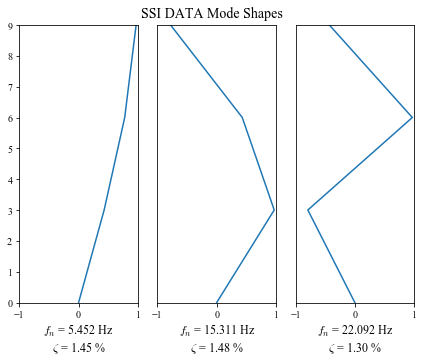

In [179]:
FNDR, ZTDR,VVDR = SSI.stable_modes(FND, ZTD, VVD, stbD, tol=0.01, spo=8)
SSI.plot_1dshapes(FNDR,ZTDR,VVDR,'SSI DATA',x,ref,fix=[0])

#### 3.3.3. Fast Multi-Order Computation of System Matrices <a name="3.3.3"></a>

The `SSI_COV_iterator` and `SSI_DATA_iterator` functions employ the conventional SSI algorithms, which identify the system matrices from observability matrix for multiple order models. Three faster algorithms are derived by Döhler and Mevel [[5](#ref5)]. Instead of solving the problem for all orders, it is shown that the least squares problems can be solved only once at the maximal desired model order $n_{2,max}$ and the system matrices of lower order models can be computed more efficiently.

The `Fast_SSI` function implements the Algorithm 2 [[5](#ref5)] for both SSI methods. It reduces significantly the computational burden for large model orders.

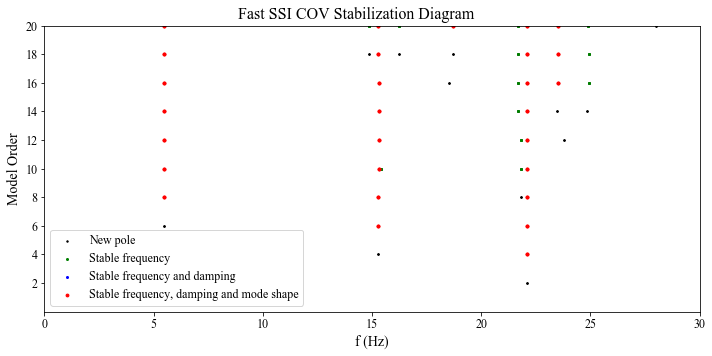

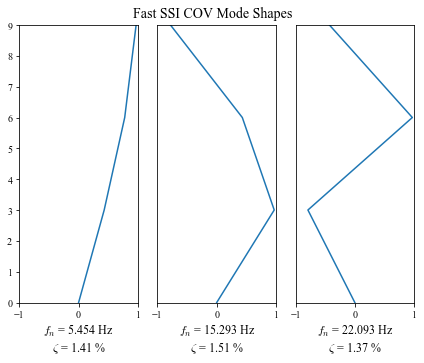

In [180]:
FNO, ZTO, VVO = SSI.Fast_SSI(yk,i,2,20,2,based='COV')
stbO = SSI.stabilization_diagram(FNO,ZTO,VVO,'Fast SSI COV', tol=tol)
FNFC, ZTFC,VVFC = SSI.stable_modes(FNO, ZTO, VVO, stbO, tol=0.01, spo=8)
SSI.plot_1dshapes(FNFC,ZTFC,VVFC,'Fast SSI COV',x,ref,fix=[0])

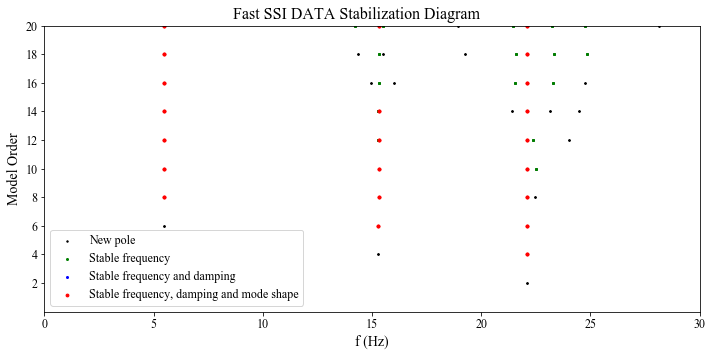

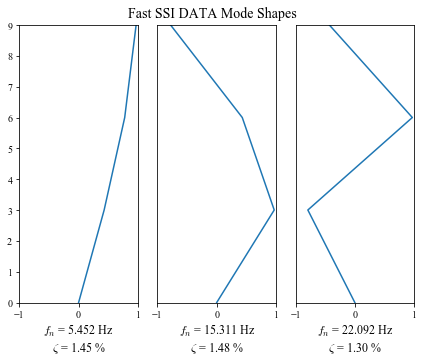

In [181]:
FNA, ZTA, VVA = SSI.Fast_SSI(yk,i,2,20,2,based='DATA')
stbA = SSI.stabilization_diagram(FNA,ZTA,VVA,'Fast SSI DATA', tol=tol)
FNFD, ZTFD,VVFD = SSI.stable_modes(FNA, ZTA, VVA, stbA, tol=0.01, spo=8)
SSI.plot_1dshapes(FNFD,ZTFD,VVFD,'Fast SSI DATA',x,ref,fix=[0])

### 3.4. Instrumental Variable (IV) method <a name="3.4"></a>

The IV uses the autoregressive moving average (ARMA) model and identifies the AR parameters only, avoiding the non-linear estimation problem caused by the MA part. It can be shown that for the modal identification, only the AR parameters are necessary. The idea is to fit the parameters for the measurement data, solving an over-determinated set of equations in a least squares sense [[10](#ref10)].

The code developed implements the reference sensors formulation proposed by Peeters [[10](#ref10)]. It is based on the reversed-time ARMA model:

$$\vec y_k^{ref} + \alpha_1^b \vec y_{k+1}^{ref} + \cdots + \alpha_p^b \vec y_{k+p}^{ref} = 
  \vec e_k^b     + \gamma_1^b \vec e_{k+1}^b     + \cdots + \gamma_p^b \vec e_{k+p}^b \tag{23}$$

Where $\vec y_k^{ref} \in \mathrm{\mathbb{R}}^{r}$ are the output reference sensors and $\vec e_k^b \in \mathrm{\mathbb{R}}^{r}$ is a white noise vector. The left-hand side is called the autoregressive (AR) part and the right-hand side the moving average (MA) part. The matrices $\alpha_1^b \in \mathrm{\mathbb{R}}^{r\times r} $ are the AR matrix parameters and the matrices $\gamma_i^b \in \mathrm{\mathbb{R}}^{r\times r}$ are the MA matrix parameters. 

The relation between the ARMA model order $p$ and its equivalent state space model $n_2$ is $p \times r = n_2$.

The AR matrices are determined by solving a set of equations with parts of the Toeplitz matrix in a least squares sense. These coefficients are grouped in a matrix called the state matrix in the companion form $ \mathbf{A}_{comp}^{b,p}$. The matrices containing the eigenvalues and eigenvectors of the companion matrix are calculated, $\mathbf{\Lambda}_d$ and $\Psi_{comp}$, respectively. The natural frequencies and damping ratios are computed from the $\mu_i$ eigenvalues.

Modal shapes are determined in a second step. The $\mathbf{G}_m^{ref}$ is computed from the first $r$ rows of the eigenvectors matrix $ \mathbf{A}_{comp}^{b,p}$:

$$\mathbf{G}_m^{ref} = \left( \Psi_{comp} [r,:] \right )^T \tag{24}$$

The matrix $\mathbf{\Gamma}_{p,m}^{ref}$ is evaluated:

$$\mathbf{\Gamma}_{p,m} = \begin{bmatrix}  
\mathbf{\Lambda}_d^{p-1}\mathbf{G}_m^{ref} & \mathbf{\Lambda}_d^{p-2}\mathbf{G}_m^{ref} & \cdots & 
\mathbf{\Lambda}_d      \mathbf{G}_m^{ref} &                         \mathbf{G}_m^{ref}   \end{bmatrix} \tag{25}$$

And finally the modal shapes:

$$\mathbf{V} = \begin{bmatrix} \mathbf{R}_p^{ref} & \mathbf{R}_{p-1}^{ref} & \cdots & \mathbf{R}_1^{ref} \end{bmatrix} 
\left ( \mathbf{\Gamma}_{p,m} \right )^{-1} \tag{26}$$

As previous methods, the identification process is performed for models with increasing orders. This process is done by the `IV_iterator` function. The maximum ARMA model order $p_{max}$ should be informed, then the maximum state space order is calculated $n_{2,max}=p_{max}\times r$ and the Toeplitz matrix is computed only once. Lower-order models $p<p_{max}$ are easily obtained by simply selecting fewer elements of the Toeplitz matrix.

Given an ARMA model of minimum order equals to 4, maximum equals to 15 and a step equals to 1:

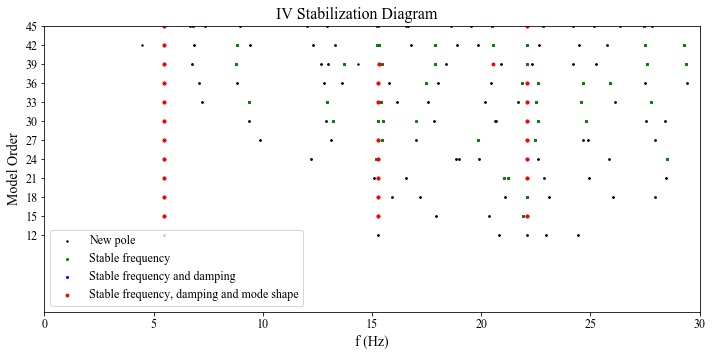

In [182]:
FNI, ZTI, VVI = SSI.IV_iterator(yk,i,4,15,1)
stbI = SSI.stabilization_diagram(FNI, ZTI, VVI,'IV', tol=tol)

The modal parameters are:

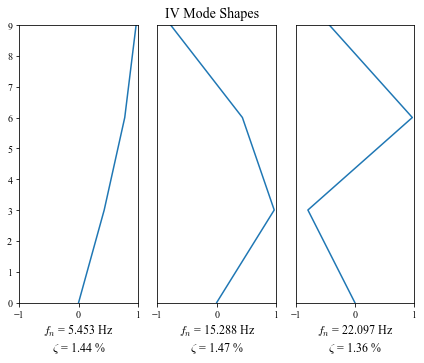

In [183]:
FNIR, ZTIR,VVIR = SSI.stable_modes(FNI, ZTI, VVI, stbI, tol=0.01, spo=8)
SSI.plot_1dshapes(FNIR,ZTIR,VVIR,'IV',x,ref,fix=[0])

## 4. Other functions <a name="4"></a>

In this section some useful functions are described.

### 4.1. Plotting building's modal parameters <a name="4.1"></a>

The `plot_3das1d` plots the modal parameters of buildings. Each modal shape must be in the columns of the argument matrix, where the row indexes `0::3` are dedicated to the translation on $x$ direction, row indexes `1::3` to the translation on $y$ direction and `2::3` to torsion $\theta_z$.

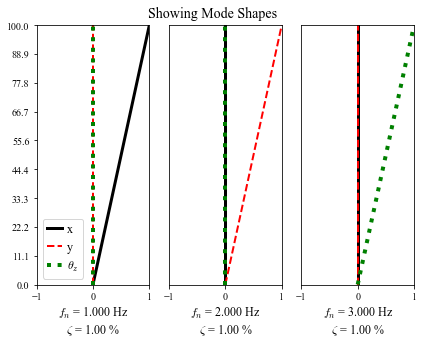

In [184]:
fnt = np.array((1,2,3))     # natural frequencies
ztt = 0.01*np.ones(3)       # damping ratios
qt  = np.array(([1,0,0],    # translation on x direction
                [0,1,0],    # translation on y direction
                [0,0,1]))   # torsion
xt  = np.array((100,))      # sensors height

SSI.plot_3das1d(fnt,ztt,qt,xt,title='Showing')

When reference sensors are used, the modal shape components of these reference sensors are positioned in the first rows of the identified modal shape. Consequently, it is necessary to rearrange the mode components. This is done by specifying the `ref` argument. For example, if the reference sensor location is `xt[1]`, `ref=(1)` must be informed.

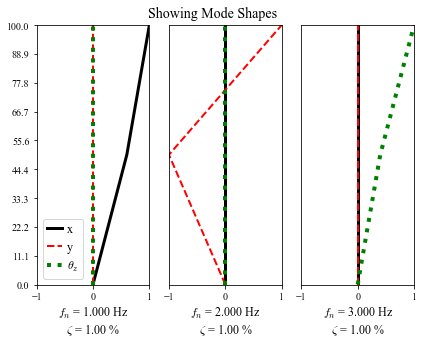

In [185]:
fnt = np.array((1,2,3))
ztt = 0.01*np.ones(3)
qt  = np.array(([  1,0,0],[0, 1,0],[0,0,  1],  # modal shape components to xt[0] height
                [0.6,0,0],[0,-1,0],[0,0,0.4])) # modal shape components to xt[1] height
xt  = np.array((100,50))

SSI.plot_3das1d(fnt,ztt,qt,xt,title='Showing',ref=(0))

### 4.2. Modal Assurance Criterion (MAC) <a name="4.2"></a>

The Modal Assurance Criterion (MAC), proposed by Allemang and Brown [[1](#ref1)], is a measure of correlation between two modal shapes. The MAC is a number between 0 and 1. It is equal to zero if the modal shapes are uncorrelated, and it is equal to one if the modal shapes are perfectly correlated. Considering the complex modal shapes $\vec \psi_i$ and $\vec \psi_j$, the MAC value is computed:

$$MAC(i,j)= \frac {\left | \vec \psi_i^T \vec \psi_j^*  \right |^2} 
              {\left ( \vec \psi_i^T \vec \psi_i^*  \right )\left ( \vec \psi_j^T \vec \psi_j^*  \right )}	\tag{27}$$

Where $(\cdot)^*$ denotes conjugate complex. The vectors $\vec \psi_i$ and $\vec \psi_j$ can be replaced by matrices whose columns are modal shapes. In this case, the use of the expression $(27)$ will be a matrix.

A useful way to view MAC values is graphically, allowing more data to be presented and understood.

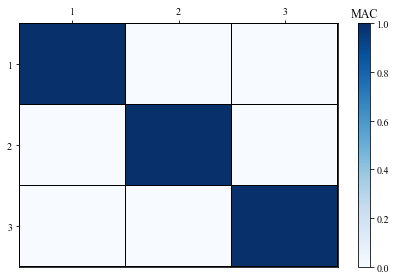

In [186]:
MAC = SSI.MAC(qt,qt,plot=True)

### 4.3. Plotting singular values <a name="4.3"></a>

The number of non-zero singular values provides an estimate of the physical mode number. When the true model order is exceeded, theoretically the values will go to zero. The Figure below shows three graphs of the same singular values. It is possible to identify six singular non-zero values, indicating that it is $n_2=6$ state space order (which is the true space state order of our 3 DOF frame example). 

For experimental data, the singular values are not exactly zero, but very small. Thus, the variation between consecutive singular values is used as an indicator. One approach is to divide all singular values by the first (and highest) value, as shown in the graph $(b)$. The matrix rank is chosen when the curve becomes asymptotic. Another approach is to divide each singular value by the previous $(c)$ forming a curve with values close to one if the values do not change in magnitude. The model order is identified when the relationship suddenly falls.

The `plot_singular_values` function plots the singular values.

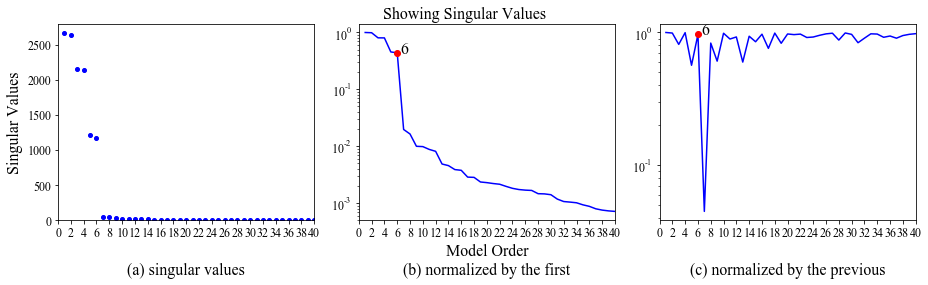

In [187]:
T = SSI.Toeplitz(yk, i)
T.method = 'Showing'
SSI.plot_singular_values(T,figsize=(13,4))

### 4.4. Reading data from file <a name="4.4"></a>

We suggest MRPy module [[11]](#ref10) in order to load time series from file. The function `MRPy.from_file()` reads a `MRPy` object from a specified file. Some formats are implemented and others may be included to expand possibilities. The default file format is `form='mrpy'`, which is a gnu zipped (`gzip`) file with a pickled object dumping (`pickle`). Files with this format can be generated as explained in [MRPy repository](https://github.com/mmaiarocha/MRPy).

The other possibilities for parameter `form` are:

   1. `'excel'`: reads an Excel file (.xlsx) containing a `pandas` data frame in a sheet named `MRPy`. The `index` attribute (first column) correspond to time instants and the further columns are the time series. Column headers are disregarded. This format allow easy communication with Excel.

   2. `'columns'`: reads a tab delimited ASCII file (.txt), where first column corresponds to time instants and following columns are the time series.

   3. `'invh'`: reads a comma delimited ASCII file (.csv), where first column corresponds to time instants (in seconds) while the last three columns correspond to accelerations in axis $x$, $y$ and $z$ measured with the cell phone app "iNVH" by Bosch. 

   4. `'MPU6050'`: reads a gnu zipped comma delimited ASCII file (.csv.gz), where first column corresponds to time instants (in seconds), the following three columns correspond to accelerations in axis $x$, $y$ and $z$, and the last three columns correspond to angular velocities in axis $x$, $y$ and $z$. This is the format used, for example, by a Raspberry Pi data logger reading a MPU6050 sensor developed for vibration monitoring.

File extensions must not be included in the file name. ASCII files are read with `numpy.genfromtxt()`. 
[Here](https://github.com/MatheusCarini/CESSIPy/blob/main/English/Example02_Smartphone.py) is an example by reading a file generated with the accelerations recorded by the cell phone app "iNVH" from Bosch.


## References

[1]<a name="ref1"></a> Allemang RJ, Brown DL. A correlation coefficient for modal vector analysis. In: Proceedings of the 1st International Modal Analysis Conference: 1982 Nov 8-10; Orlando, USA; 1982. p. 110-6.

[2]<a name="ref2"></a> Bendat JS, Piersol AG. Random data: analysis and measurement procedures. 4th ed. New York: Wiley; 2010.

[3]<a name="ref3"></a> Brincker R, Zhang L, Andersen P. Modal identification from ambient responses using frequency domain decomposition. In: Proceedings of the 18th International Modal Analysis Conference: 2000 Feb 7-10; San Antonio, USA; 2000. p. 625-30.

[4]<a name="ref4"></a> Brincker R, Ventura CE, Andersen P. Damping estimation by frequency domain decomposition. In: Proceedings of the 19th International Modal Analysis Conference: 2001 Feb 5-8; Kissimmee, USA; 2001. p. 698-703.

[5]<a name="ref5"></a> Döhler M, Mevel L. Fast multi-order computation of system matrices in subspace-based system identification. Control Eng Pract 2012;20(9):885-94. https://doi.org/10.1016/j.conengprac.2012.05.005

[6]<a name="ref6"></a> Ewins DJ. Modal testing: theory, practice and application. 2nd ed. Baldock: Research Studies; 2000.

[7]<a name="ref7"></a> Felber AJ. Development of a hybrid bridge evaluation system (Ph.D. thesis), Vancouver: University of British Columbia; 1993. 

[8]<a name="ref8"></a> Hu W-H, Cunha Á, Caetano E, Magalhães F, Moutinho C. Labview toolkits for output-only modal identification and long-term dynamic structural monitoring. Struct Infrastruct Eng 2010;6(5):557-74. https://doi.org/10.1080/15732470903068672

[9]<a name="ref9"></a> Van Overschee P, De Moor B. Subspace identification for linear systems: theory - implementation – applications. Leuven: Kluwer; 1996. 

[10]<a name="ref10"></a> Peeters B. System identification and damage detection in civil engineering (Ph.D. thesis), Leuven: Katholieke Universiteit Leuven; 2000.

[11]<a name="ref11"></a> Rocha MM. Multivariate random processes with Python. 2020, URL https://github.com/mmaiarocha/MRPy

[12]<a name="ref12"></a> Rodrigues J. Identificação Modal Estocástica: métodos de análise e aplicações em estruturas de engenharia civil (Ph.D. thesis), Porto, Portugal: University of Porto; 2004. https://hdl.handle.net/10216/11964